In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

Загружаем определенное количество изображений и масштабируем их

Изначально отбираем подходящие снимки, т.к. качество датасета оставляет желать лучшего. Также в нем есть битые файлы, например 3491.jpg в Cat и 7133 в Dog.jpg

In [63]:
# Параметры
IMAGE_SIZE = (64, 64)  # можно изменить на (32, 32) или другое

def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        try:
            img = imread(path)
            img = resize(img, IMAGE_SIZE, anti_aliasing=True)
            images.append(img.flatten())
            labels.append(label)
        except Exception as e:
            print(f"Ошибка при обработке файла {filename}: {e}")
    return images, labels

# Загрузка всех изображений из папок
cat_images, cat_labels = load_images_from_folder('data/Cat', 1)
dog_images, dog_labels = load_images_from_folder('data/Dog', 0)

# Объединение
X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Всего изображений: {len(X)}")
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Всего изображений: 600
Размер обучающей выборки: 480
Размер тестовой выборки: 120


Обучение без PCA

In [64]:
clf_logreg = LogisticRegression(max_iter=300)
clf_tree = RandomForestClassifier(n_estimators=100, random_state=42)

clf_logreg.fit(X_train, y_train)
clf_tree.fit(X_train, y_train)

acc_logreg = accuracy_score(y_test, clf_logreg.predict(X_test))
acc_tree = accuracy_score(y_test, clf_tree.predict(X_test))

print(f"Логистическая регрессия (без PCA): {acc_logreg:.3f}")
print(f"Дерево решений (без PCA): {acc_tree:.3f}")

Логистическая регрессия (без PCA): 0.650
Дерево решений (без PCA): 0.642


Обучение с PCA

Точность линейной регрессии от количества компонент PCA

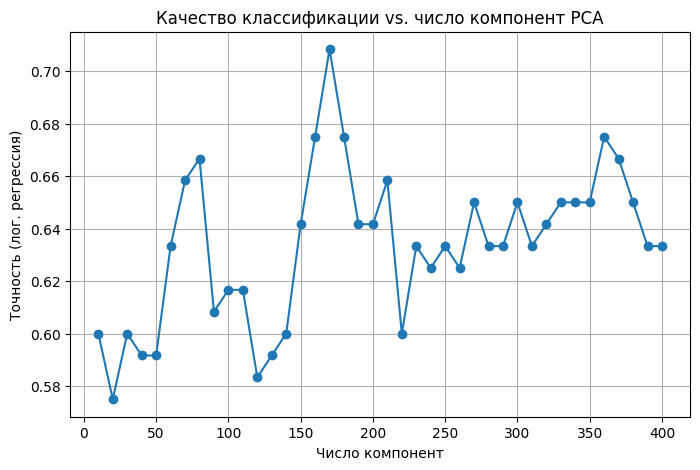

In [74]:
explained_variances = []
accuracies_logreg = []

components_range = list(range(10, 401, 10))

for n_components in components_range:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_pca, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test_pca))
    accuracies_logreg.append(acc)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

# График: точность vs. число компонент
plt.figure(figsize=(8, 5))
plt.plot(components_range, accuracies_logreg, marker='o')
plt.title("Качество классификации vs. число компонент PCA")
plt.xlabel("Число компонент")
plt.ylabel("Точность (лог. регрессия)")
plt.grid(True)
plt.show()

Как видно, график сильно зашумлен, но остается примерно на одном месте. Можно заметить в начале очень сильное влияние шумов на обучение(каждый запуск пики и низины перемещаются), относительную стабильность посередине и, как следствие раннего переобучения, небольшой нисходящий тренд в конце(на данном графике он представлен не так явно, т.к. не хватает размера датасета, чтобы приблизиться к максимальному числу компонент)

Теперь сравним регрессию со случайным лесом на разном числе компонент PCA

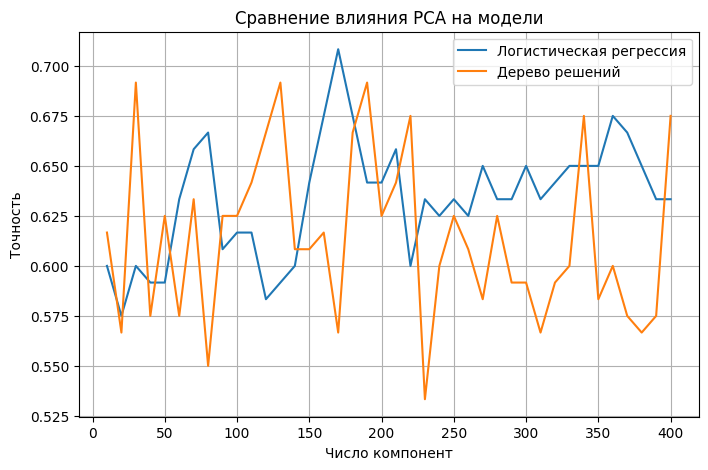

In [81]:
accuracies_tree = []
for n_components in components_range:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_pca, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test_pca))
    accuracies_tree.append(acc)

# Сравнительный график
plt.figure(figsize=(8, 5))
plt.plot(components_range, accuracies_logreg, label="Логистическая регрессия")
plt.plot(components_range, accuracies_tree, label="Дерево решений")
plt.title("Сравнение влияния PCA на модели")
plt.xlabel("Число компонент")
plt.ylabel("Точность")
plt.legend()
plt.grid(True)
plt.show()

Видим, что случайный лес в среднем эквивалентен линейной регрессии, но есть места - выбросы, на которых либо регрессия, либо лес значительно улучшают свой результат(конечно же это просто следствие шума, и работать это будет только на нашем тесте), так что можно сказать, что в среднем они имеют одинаковую точность. Но стоит заметить, что случайный лес чуть более шумный и неустойчивый по сравнению с линейной регрессией

Теперь выведим график объясняемости дисперсии от числа компонент

Также найдем первую компоненту, объясняющую 90% дисперсий

Компонент для объяснения 90% дисперсии: 94


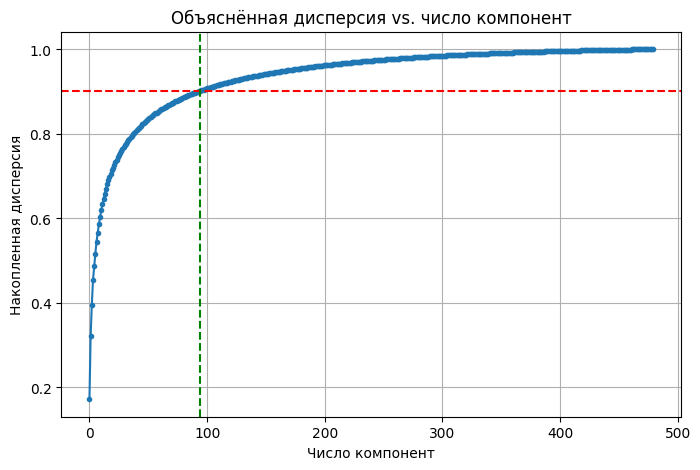

In [82]:
pca_full = PCA().fit(X_train)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Компонент для объяснения 90% дисперсии: {n_components_90}")

# График: дисперсия vs. компоненты
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='.')
plt.axhline(0.9, color='red', linestyle='--')
plt.axvline(n_components_90, color='green', linestyle='--')
plt.title("Объяснённая дисперсия vs. число компонент")
plt.xlabel("Число компонент")
plt.ylabel("Накопленная дисперсия")
plt.grid(True)
plt.show()

Выведем первые 10 компонент

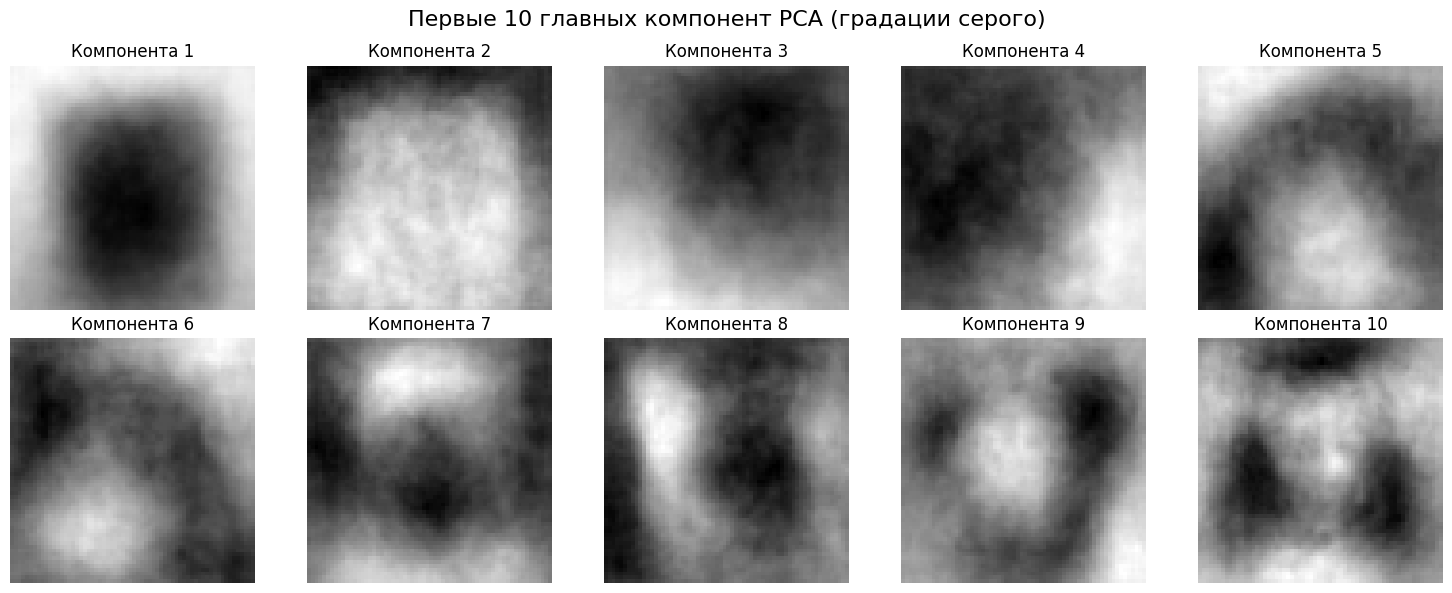

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
components = pca.components_[:10]

for i, ax in enumerate(axes.flat):
    component = components[i].reshape(*IMAGE_SIZE, 3)
    component_gray = rgb2gray(component)

    component_gray -= component_gray.min()
    component_gray /= component_gray.max()

    ax.imshow(component_gray, cmap='gray')
    ax.set_title(f"Компонента {i + 1}")
    ax.axis('off')

plt.suptitle("Первые 10 главных компонент PCA (градации серого)", fontsize=16)
plt.tight_layout()
plt.show()

Компоненты получились отличными, благодаря ручному отбору датасета: на многих из них можно разглядеть очертания мордочек кошек и собак